In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import numpy as np
import string
import random
import string
from sklearn import linear_model
import pandas
from sklearn.metrics import mean_squared_error

def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

# Read data from file and return a generator of lines, each line is a dictionary
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
# read data from file and return a generator of user, game, and dictionary
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d
# 
def UsersGames(data):
    usergames = defaultdict(set)
    gameusers = defaultdict(set)
    for u, g, d in data:
        usergames[u].add(g)
        gameusers[g].add(u)
    return usergames, gameusers


# allData
allHours = []
for l in readJSON("train.json.gz"):
    allHours.append(l)


d:\SDK\python\anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\SDK\python\anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\SDK\python\anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
d:\SDK\python\anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# split data into train and valid
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]

In [3]:
gameCount = defaultdict(int) # Number of times each game appears, store in dictionary, key is gameID, value is number of times it appears
totalPlayed = 0 # Total number of games appeared ( counts duplicates )

for user,game,_ in hoursTrain:
    gameCount[game] += 1
    totalPlayed += 1

# calculate the most popular games
mostPopular = [(gameCount[x], x) for x in gameCount] # number of times a game appears, gameID 
mostPopular.sort()
mostPopular.reverse()
return1 = set() # set of most popular games
count = 0

# for ic, i in mostPopular:
#   count += ic
#   return1.add(i)
#   if count > totalPlayed*0.7: break

# 根据28定理设的新方案
for ic, i in mostPopular:
  count += 1
  return1.add(i)
  if count > len(gameCount)*0.20: break


most_pop_id = [x for x in mostPopular[0:int(len(mostPopular)/10)]] # 取前10%的游戏, 认为其一定会被玩
least_pop_id = [x for x in mostPopular[len(mostPopular) - int(len(mostPopular)/10):len(mostPopular)]] # 取后10%的游戏, 认为其一定不会被玩

# 根据popularity给游戏打分
def get_score_by_popularity(u,g):
    return gameCount[g]/totalPlayed

    if g in most_pop_id:
        return 1
    elif g in least_pop_id:
        return -1
    else:
        return 0.5


def get_prediction(u,g):
    if g in return1:
        return 1
    else:
        return 0

### Question 1
# Evaluate baseline strategy
allGames = set([g for u, g, d in hoursTrain + hoursValid]) # 所有gameid的集合

usergames,gameusers = UsersGames(hoursTrain + hoursValid) # usergames: 每个user玩过的game; gameusers:每个game的user

augmentedValidationSet = []

valid1 = []
valid2 = []

answers = {}
for u,i,d in hoursValid:
    valid1.append((u, i, 1))
    valid2.append((u, random.choice(list(allGames - usergames[u])), 0))
augmentedValidationSet = valid1 + valid2 # 加入一些用户没玩过的游戏作为负样本


# 利用55开的分布,不直接判定为1或0,而是根据popularity给一个分数, 将得分在前50%的判定为1,后50%的判定为0
popscores = np.asarray([get_score_by_popularity(u, g) for u, g, p in augmentedValidationSet])
mid_score = numpy.median(popscores)
sorted_scores = sorted(popscores)
top = sorted_scores[int(len(sorted_scores)*0.80)]
tail = sorted_scores[int(len(sorted_scores)*0.80)]

predictions = numpy.zeros(len(augmentedValidationSet))
# 随机预测0或1
predictions = np.random.randint(2, size=len(augmentedValidationSet))

# predictions[np.where(popscores <= tail)] = 0
# predictions[np.where(popscores > top)] = 1
predictions[np.where(popscores>=mid_score)] = 1
predictions[np.where(popscores<mid_score)] = 0



acc = [1 if predictions[i] == p else 0 for i, (u, g, p) in enumerate(augmentedValidationSet)]


# predictions = [1 if get_prediction(u, g)==p else 0 for u,g,p in augmentedValidationSet]

accuracy = sum(acc)/len(augmentedValidationSet)

answers['Q1'] = accuracy
assertFloat(answers['Q1'])
print(accuracy)

0.7030703070307031


In [4]:
usergames_train,gameusers_train = UsersGames(hoursTrain)
# 返回两个序列的Jaccard相似度
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

# 计算Jaccard相似度
def calJaccard(u,g):
    maxJaccrd = 0
    threshold34 = 0.03035
    predictionsJaccard = []
    gamesset = usergames_train.get(u)
    if gamesset is None:
        return 0
    for g1 in gamesset:
        if g==g1:
            continue
        j = Jaccard(gameusers_train.get(g1),gameusers_train.get(g))
        if j>maxJaccrd:
            maxJaccrd = j
    return maxJaccrd    


threshold34 = 0.03035
# 利用Jaccard相似度判定
def predictJaccard(u,g):
    maxJaccrd = calJaccard(u,g)
    if maxJaccrd > threshold34:
        return 1
    else:
        return 0

jacc_score = np.asarray([calJaccard(u, g) for u, g, p in augmentedValidationSet])

0.9904990499049905


0.6733173317331733


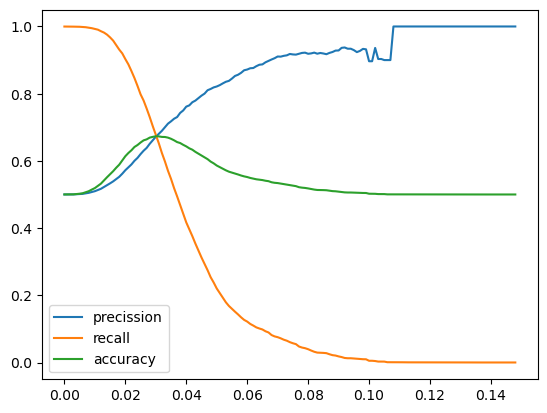

In [5]:
import matplotlib.pyplot as plt

# threshold = np.mean(jacc_score)
gt = np.asarray([p for u, g, p in augmentedValidationSet])

def cal_matr(threshold):
    predictions = np.zeros(len(augmentedValidationSet))
    predictions[np.where(jacc_score > threshold)] = 1
    precission = np.sum(np.logical_and(predictions, gt)) / np.sum(predictions)
    recall     = np.sum(np.logical_and(predictions, gt)) / np.sum(gt)
    accuracy3        = np.sum(predictions == gt) / len(predictions)    
    return precission, recall, accuracy3

# threshold = np.range(0, np.max(jacc_score), 0.001)
threshold =  np.arange(0, np.max(jacc_score), 0.001)
# 分别计算对应trehold下的precision, recall, accuracy
precission = np.zeros(len(threshold))
recall = np.zeros(len(threshold))
accuracy3 = np.zeros(len(threshold))
for i in range(len(threshold)):
    precission[i], recall[i], accuracy3[i] = cal_matr(threshold[i])
# 绘制precision, recall, accuracy随threshold的变化曲线
plt.plot(threshold, precission)
plt.plot(threshold, recall)
plt.plot(threshold, accuracy3)
plt.legend(['precission', 'recall', 'accuracy'])

print(np.max(accuracy3))


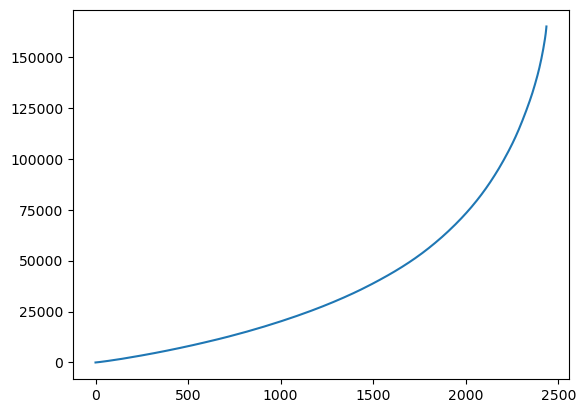

In [6]:
#绘制游戏出现次数 (标注坐标轴)
countarray = np.asarray([gameCount[x] for x in gameCount])

sorted_count = sorted(countarray)
# 前缀和
sorted_count = np.cumsum(sorted_count)
plt.plot(sorted_count)
# plt.hist(gameCount.values(), bins=100)

In [80]:
gt = np.asarray([p for u, g, p in augmentedValidationSet])
user = np.asarray([u for u, g, p in augmentedValidationSet])
game = np.asarray([g for u, g, p in augmentedValidationSet])


return1 = set() # set of most popular games
pop_high_count = 0
pop_low_count = 0
count = 0
# 根据28定理设的新方案
for ic, i in mostPopular:
  count += ic
  if count > len(gameCount)*0.2: 
    pop_high_count = ic
    break

count = 0
for ic, i in mostPopular:
  count += 1
  if count > len(gameCount)*0.80: 
    pop_low_count = ic    
    break

print("pop_high_count: ", pop_high_count, "pop_low_count: ", pop_low_count)
val_user_count = np.asarray([len(gameusers[g]) for u, g, p in augmentedValidationSet])
mid_count = np.median(val_user_count)
mid_jcc = np.median(jacc_score)
print("mid_count: ", mid_count, "mid_jcc: ", mid_jcc)


pred = np.zeros(len(gt))
jacc_high = (jacc_score > 0.05)
jacc_low = (jacc_score <= 0.02)
pop_high = (val_user_count > pop_high_count)
pop_low = (val_user_count <= pop_low_count)
low = np.logical_or(jacc_low, pop_low)
heigh = np.logical_or(jacc_high, pop_high)
sure = np.logical_or(low, heigh)
not_sure = np.logical_not(sure)
pred[low] = 0
pred[heigh] = 1

res_true = len(pred)/2 - np.sum(pred)

js = 0.05
pc = pop_high_count
while res_true>0:
    js -= 0.0001
    pc -= 10
    print("js: ", js, "pc: ", pc, "res_true: ", res_true)
    for i in range(len(pred)):
        if not_sure[i]:
            if jacc_score[i] > js or val_user_count[i] > pc:
                pred[i] = 1
                res_true -= 1
                not_sure[i] = False
        if res_true <= 0:
            break
# pred = np.zeros(len(gt))
# res_true = sum(pred) 
# while res_true < len(pred)/2:
#     print("mid_count: ", mid_count, "mid_jcc: ", mid_jcc)
#     for i in range(len(pred)): 
#         if jacc_score[i] > mid_jcc and val_user_count[i] > mid_count and not_sure[i]:
#             pred[i] = 1
#     res_true = np.sum(pred)
#     mid_count -= 1
#     mid_jcc -= 0.001
print("true of sure: ", np.sum(pred[sure]== gt[sure]), "len of sure: ", np.sum(sure))
precission = np.sum(pred[sure]== gt[sure]) /np.sum(sure)
print(" played: ", np.sum(pred))

acc = np.sum(pred == gt) / len(gt)
# print("acc: ", acc)
print("precission: ", precission, "acc: ", acc)






pop_high_count:  1038 pop_low_count:  20
mid_count:  64.0 mid_jcc:  0.030303030303030304
js:  0.0499 pc:  1028 res_true:  7317.0
js:  0.0498 pc:  1018 res_true:  7276.0
js:  0.049699999999999994 pc:  1008 res_true:  7270.0
js:  0.04959999999999999 pc:  998 res_true:  7238.0
js:  0.04949999999999999 pc:  988 res_true:  7232.0
js:  0.049399999999999986 pc:  978 res_true:  7202.0
js:  0.04929999999999998 pc:  968 res_true:  7184.0
js:  0.04919999999999998 pc:  958 res_true:  7170.0
js:  0.04909999999999998 pc:  948 res_true:  7155.0
js:  0.048999999999999974 pc:  938 res_true:  7129.0
js:  0.04889999999999997 pc:  928 res_true:  7100.0
js:  0.04879999999999997 pc:  918 res_true:  7084.0
js:  0.048699999999999966 pc:  908 res_true:  7073.0
js:  0.04859999999999996 pc:  898 res_true:  7047.0
js:  0.04849999999999996 pc:  888 res_true:  7033.0
js:  0.04839999999999996 pc:  878 res_true:  7009.0
js:  0.048299999999999954 pc:  868 res_true:  6993.0
js:  0.04819999999999995 pc:  858 res_true:  

In [ ]:
predictions = open("predictions_Played.csv", 'w')
for l in open("pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    baselinepre = get_prediction4(u, g)
    jpre = predictJaccard(u, g)
    if baselinepre or jpre:
        pred = 1
    else:
        pred = 0

    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()



